In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.data'
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(url, sep='\t', names=column_names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
# Перенумерация пользователей и элементов
user_id_map = {user_id: i for i, user_id in enumerate(df['user_id'].unique())}
item_id_map = {item_id: i for i, item_id in enumerate(df['item_id'].unique())}

df['user_id'] = df['user_id'].map(user_id_map)
df['item_id'] = df['item_id'].map(item_id_map)

In [5]:
user_id_map = {user_id: i for i, user_id in enumerate(df['user_id'].unique())}
item_id_map = {item_id: i for i, item_id in enumerate(df['item_id'].unique())}

df['user_id'] = df['user_id'].map(user_id_map)
df['item_id'] = df['item_id'].map(item_id_map)

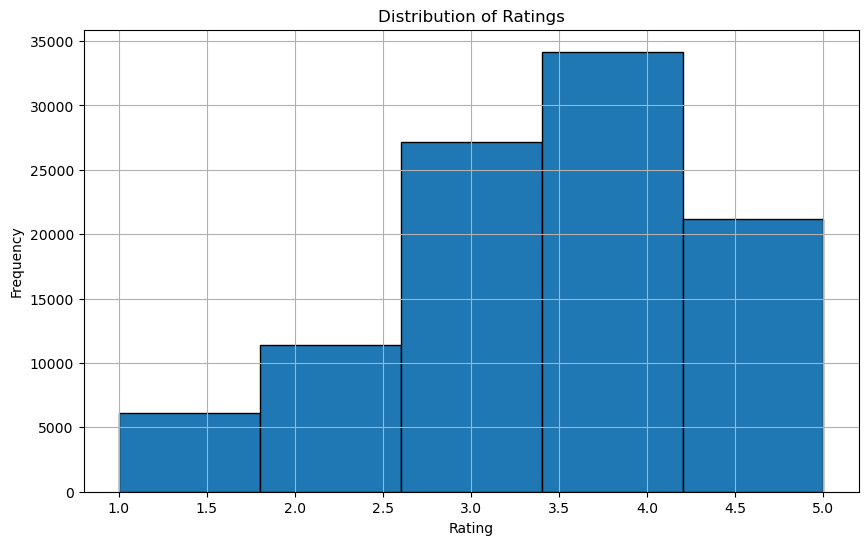

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=5, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

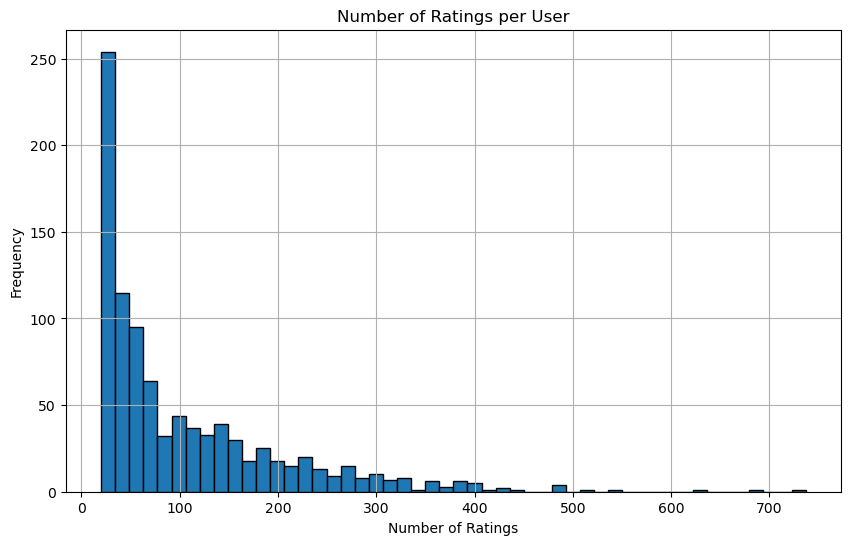

In [7]:
user_rating_counts = df.groupby('user_id')['rating'].count()
plt.figure(figsize=(10, 6))
plt.hist(user_rating_counts, bins=50, edgecolor='black')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

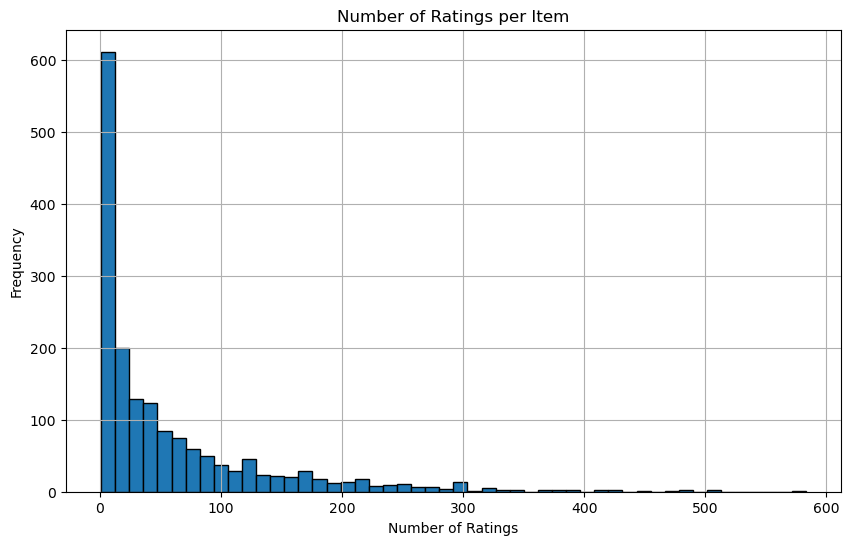

In [8]:
item_rating_counts = df.groupby('item_id')['rating'].count()
plt.figure(figsize=(10, 6))
plt.hist(item_rating_counts, bins=50, edgecolor='black')
plt.title('Number of Ratings per Item')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
class MovieLensDataset(Dataset):
    def __init__(self, df):
        self.data = df[['user_id', 'item_id', 'rating']].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            'user_id': self.data[idx][0],
            'item_id': self.data[idx][1],
            'rating': self.data[idx][2]
        }
        return sample

    
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = MovieLensDataset(train_df)
val_dataset = MovieLensDataset(val_df)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [10]:

class RecurrentModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_size, hidden_size, dropout=0.5):
        super(RecurrentModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)
        self.gru = nn.GRU(embedding_size * 2, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, user, item):
        user_embedded = self.user_embedding(user)
        item_embedded = self.item_embedding(item)
        embedded = torch.cat([user_embedded, item_embedded], dim=1).unsqueeze(1)
        output, _ = self.gru(embedded)
        output = self.fc(self.dropout(output[:, -1, :]))
        return output.squeeze()

num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()

model = RecurrentModel(num_users=num_users, num_items=num_items, embedding_size=64, hidden_size=64)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.MSELoss()


In [11]:
num_epochs = 10
patience = 2
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
best_val_loss = float('inf')  
patience_counter = 0

In [12]:

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        user, item, rating = batch['user_id'].long(), batch['item_id'].long(), batch['rating'].float()

        if user.max() >= num_users or item.max() >= num_items:
            print(f"Index out of range: user max {user.max()}, item max {item.max()}")
            continue

        optimizer.zero_grad()
        outputs = model(user, item)
        loss = criterion(outputs, rating)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(batch)
    train_losses.append(train_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            user, item, rating = batch['user_id'].long(), batch['item_id'].long(), batch['rating'].float()

            if user.max() >= num_users or item.max() >= num_items:
                print(f"Index out of range: user max {user.max()}, item max {item.max()}")
                continue

            outputs = model(user, item)
            loss = criterion(outputs, rating)
            val_loss += loss.item() * len(batch)
    val_losses.append(val_loss / len(val_loader.dataset))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


Epoch 1/10: 100%|██████████| 1250/1250 [00:09<00:00, 132.30it/s]


Epoch [1/10], Train Loss: 0.4029, Val Loss: 0.1537


Epoch 2/10: 100%|██████████| 1250/1250 [00:06<00:00, 193.80it/s]


Epoch [2/10], Train Loss: 0.1099, Val Loss: 0.0668


Epoch 3/10: 100%|██████████| 1250/1250 [00:06<00:00, 183.35it/s]


Epoch [3/10], Train Loss: 0.0795, Val Loss: 0.0565


Epoch 4/10: 100%|██████████| 1250/1250 [00:06<00:00, 181.41it/s]


Epoch [4/10], Train Loss: 0.0735, Val Loss: 0.0538


Epoch 5/10: 100%|██████████| 1250/1250 [00:07<00:00, 166.00it/s]


Epoch [5/10], Train Loss: 0.0701, Val Loss: 0.0526


Epoch 6/10: 100%|██████████| 1250/1250 [00:07<00:00, 166.07it/s]


Epoch [6/10], Train Loss: 0.0675, Val Loss: 0.0514


Epoch 7/10: 100%|██████████| 1250/1250 [00:07<00:00, 156.43it/s]


Epoch [7/10], Train Loss: 0.0655, Val Loss: 0.0505


Epoch 8/10: 100%|██████████| 1250/1250 [00:08<00:00, 146.46it/s]


Epoch [8/10], Train Loss: 0.0632, Val Loss: 0.0497


Epoch 9/10: 100%|██████████| 1250/1250 [00:08<00:00, 154.10it/s]


Epoch [9/10], Train Loss: 0.0617, Val Loss: 0.0490


Epoch 10/10: 100%|██████████| 1250/1250 [00:07<00:00, 162.67it/s]


Epoch [10/10], Train Loss: 0.0606, Val Loss: 0.0484


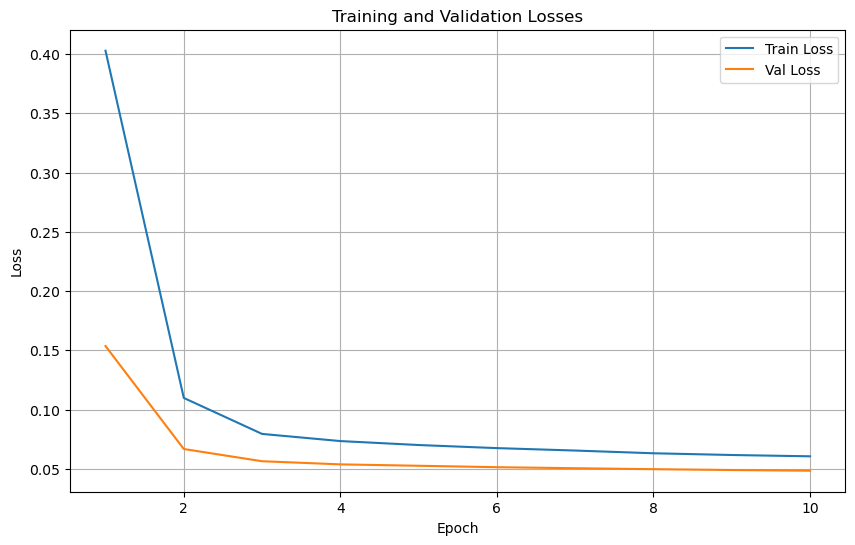

In [13]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Demo

In [14]:
model.eval()


RecurrentModel(
  (user_embedding): Embedding(943, 64)
  (item_embedding): Embedding(1682, 64)
  (gru): GRU(128, 64, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
sample_pairs = val_df.sample(5)


In [16]:
sample_users = torch.tensor(sample_pairs['user_id'].values).long()
sample_items = torch.tensor(sample_pairs['item_id'].values).long()

In [17]:
with torch.no_grad():
    predictions = model(sample_users, sample_items)

In [18]:
for i in range(len(sample_pairs)):
    print(f"ID користувача: {sample_pairs.iloc[i]['user_id']}, "
          f"ID фільма: {sample_pairs.iloc[i]['item_id']}, "
          f"Фактичний рейтинг: {sample_pairs.iloc[i]['rating']}, "
          f"Передбачений рейтинг: {predictions[i].item():.2f}")

ID користувача: 58, ID фільма: 1398, Фактичний рейтинг: 5, Передбачений рейтинг: 3.34
ID користувача: 907, ID фільма: 1009, Фактичний рейтинг: 3, Передбачений рейтинг: 3.68
ID користувача: 673, ID фільма: 77, Фактичний рейтинг: 4, Передбачений рейтинг: 3.84
ID користувача: 674, ID фільма: 361, Фактичний рейтинг: 4, Передбачений рейтинг: 3.77
ID користувача: 56, ID фільма: 238, Фактичний рейтинг: 4, Передбачений рейтинг: 3.97


In [19]:
from sklearn.metrics import mean_absolute_error

model.eval()
val_predictions = []
val_true_ratings = []

with torch.no_grad():
    for batch in val_loader:
        user, item, rating = batch['user_id'].long(), batch['item_id'].long(), batch['rating'].float()

        if user.max() >= num_users or item.max() >= num_items:
            print(f"Index out of range: user max {user.max()}, item max {item.max()}")
            continue

        outputs = model(user, item)
        val_predictions.extend(outputs.numpy())
        val_true_ratings.extend(rating.numpy())

mae = mean_absolute_error(val_true_ratings, val_predictions)
print(f'Mean Absolute Error on the validation set: {mae:.4f}')


Mean Absolute Error on the validation set: 0.8222


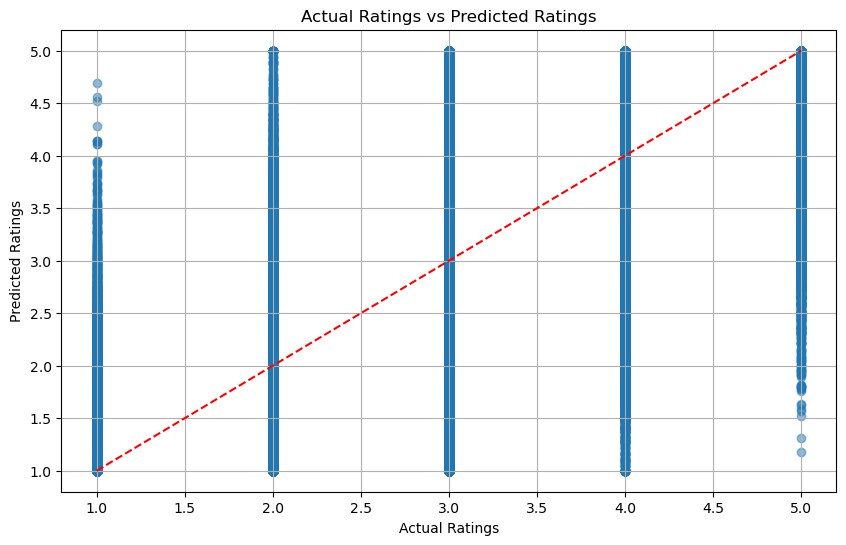

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(val_true_ratings, val_predictions, alpha=0.5)
plt.plot([1, 5], [1, 5], color='red', linestyle='--')
plt.title('Actual Ratings vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()